 # **<center>  Lab 10 - Non- Local Means Filtering**</center> 
### **Problem Statement:**

$\color{blue}{\text{In this experiment, we will implement non-local means (NLM) filtering algorithm for the application of denoising.}}$
$\color{blue}{\text{You are given a noisy image, g (krishna 0 001.png), corresponding to a latent image, f (krishna.png),corrupted with }}$
$\color{blue}{\text{additive Gaussian noise of mean 0 and variance 0.001.}}$
 $\color{blue}{\text{Your task is to apply NLM filtering on g following the steps in the given pseudocode to arrive at the denoised image, $\hat{f}$.}}$
$\color{blue}{\text{The parameters of the algorithm are the search neighbourhood radius W , the similarity neighbourhood radius Wsim and the filter parameter $σ_{NLM}$ .}}$ $\color{blue}{\text{A radius of W at a pixel denotes a window size of $(2W + 1) × (2W + 1)$ around that pixel. The same applies to $W_{sim}$.}}$ 

$\color{blue}{\text{Q1. Show plots between the PSNR between f and $\hat{f}$ (y-axis) for different NLM filter parameter values $σ_{NLM} = 0.1 to 0.5$}}$
$\color{blue}{\text{ in steps of 0.1 (x-axis) for the following search radius and similarity radius
settings:}}$


$\color{blue}{\text{(a) W = 3, Wsim = 3,}}$

$\color{blue}{\text{(b) W = 5, Wsim = 3.}}$

$\color{blue}{\text{Show two plots in the same window with two different colours corresponding to (a) and (b). Compare the PSNR plots }}$
$\color{blue}{\text{with the baseline PSNR between the noisy image g and the latent image f.}}$



####**Solution:**

### 1. Importing required Libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

### 2. Reading the images
Reading the given images.  The images are divided to be in the range $[0, 1]$ to prevent overflow errors for the given values of $\sigma_{g}$ and $\sigma_

*Assumption: The given images are present in the same directory as the notebook.*

In [2]:
krishna = imread('krishna.png')/255
krishna_noisy = imread('krishna_0_001.png')/255

### 3. Function for Zero Padding of image
Given the pad size and the image, this function returns the zero padded image so that after further processing the output image is of same size as the input image.


In [3]:
def zero_pad_image(image, pad_size):
    x, y = np.shape(image)
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size))
    padded_image[pad_size:-pad_size, pad_size:-pad_size] = image
    return padded_image

### 4. Function for  Zero Padding of RGB Image
This Function zero pads the RGB image.

In [4]:
def zero_pad_image_RGB(image, w, w_sim):
    x, y, _ = np.shape(image)
    pad_size = w+w_sim
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size, 3))
    for i in range(3):
        padded_image[pad_size:-pad_size,
                     pad_size:-pad_size, i] = image[:, :, i]
    return padded_image

### 5. Function for PSNR Calculation
Calculate the PSNR between a noisy image and its underlying latent image. PSNR in decibels (dB) is defined as 

$$
20log_{10}\left(\frac{MAX_{f}}{\sqrt{MSE}}\right)
$$

$MAX_{f}$ is the maximum intensity value in the underlying image 

$MSE$ is the mean-squared error between the noisy image and the underlying image. 

*If the $MSE$ is zero, return a really high but finite value to prevent division by zero errors.*




In [5]:
def PSNR(latent_image, noisy_image):
    mse = np.mean((noisy_image-latent_image)**2)
    if mse > 0:
        return 20*np.log10(np.max(latent_image)/np.sqrt(mse))
    else:
        return np.float128('2e315')

### 6. Function for measuring intensity of gaussian
Given an image patch $\mathcal{N}_{p}$ around a pixel $p$, the weight $w_{pq}$ another patch $\mathcal{N}_{q}$ around a pixel $q$ gets during NLM filtering depends on the forbenius norm of the difference between $\mathcal{N}_{p}$ and $\mathcal{N}_{q}$.

$$
w_{pq} \propto exp\left[{\frac{\|\mathcal{N}_{p}-\mathcal{N}_{q}\|^{2}_{F}}{2\sigma^{2}}}\right]
$$

$\sigma$ decides the sensitivity. If $\sigma$ is small, $p$ will get a very low contribution from $q$ even if $\mathcal{N}_{q}$ is slightly different from $\mathcal{N}_{p}$ and vice versa for large value of $\sigma$.

In [6]:
def intensity_gaussian(p, q, sigma):
    if sigma > 0:
        return np.exp(np.sum((-1*(p-q)**2)/(2*sigma**2)))
    else:
        if np.sum(np.abs(p-q)) == 0:
            return 1
        else:
            return 0

### 7. Function for NLM Local

Given an image patch $\mathcal{N}_{p}$ of size $(2W_{sim}+1)\times (2W_{sim}+1)$ around a pixel $p$, calculate the filtered image intensity at $p, g(p)$. 

$$
g(p) = \frac{1}{Z_{p}}\Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})f(q)
$$

$G_{p}$ is a neighborhood of size $(2W+1)\times (2W+1)$ around $p$, $G_{\sigma}$ is the Gaussian intensity weight for a given $\sigma$ as defined in the previous section, and, $f(q)$ is the image intensity at pixel $q$. 

$Z_{p}$ is a normalizing constant given by:

$$
Z_{p} = \Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})
$$

This is to make sure that we do not brighten or darken the image while filtering.

In [7]:
def NLM_local(impatch, surroundings, d, W_sim, sigma, return_kernel=False):
    # create a weight matrix of the required size. It is to be noted
    # here that the d input is the sum W + W_sim and hence, W_sim is 
    # subtracted whenever required 
    weights = np.zeros((2*d+1 - 2*W_sim, 2*d+1 - 2*W_sim))
    filtered_val = 0
    for i in range(W_sim, 2*d+1 - W_sim):
        for j in range(W_sim, 2*d+1 - W_sim):
            # get the patch around another pixel of the size (2*W_sim+1, 2*W_sim+1)
            q = surroundings[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
            # get the weights
            weights[i-W_sim, j-W_sim] = intensity_gaussian(impatch, q, sigma)
            # increment the filtered value
            filtered_val += weights[i-W_sim, j-W_sim]*surroundings[i, j]
    # if the kernel is required for visualization, return it. Else return
    # only the filtered value. Normalize both the kernel and the weights so
    # that the weights sum up to 1 and we do not brighten or dim the image
    if return_kernel:
        return filtered_val/np.sum(weights), weights/np.sum(weights)
    else:
        return filtered_val/np.sum(weights)

### 8. Function for NLM

Perform non-local means on an RGB image for given values of NLM search neighbourhood radius $W$, the similarity neighbourhood radius $W_{sim}$, and the filter parameter $\sigma_{NLM}$. The filtered intensity at a pixel $p$, $g(p)$, is calculated as described in the previous section. Do the same for each pixel in the image. For an RGB image, each channel is filtered independently.

In [8]:
def NLM(image, W, W_sim, sigma):
    # get the image shape
    x, y, _ = np.shape(image)
    # zero pad the image
    padded_image = zero_pad_image_RGB(image, W, W_sim)
    d = W + W_sim
    filtered_image = np.zeros((x, y, 3))
    # for each channel
    for channel in range(3):
        padded_image_channel = padded_image[:, :, channel]
        for i in range(d, x+d):
            for j in range(d, y+d):
                # get the patch around a pixel of shape (2*W_sim+1, 2*W_sim+1)
                impatch = padded_image_channel[i -
                                               W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
                # get its surroundings of shape (2*W+1, 2*W+1)
                surroundings = padded_image_channel[i-d:i+d+1, j-d:j+d+1]
                # get the filtered value
                filtered_image[i-d, j-d, channel] = NLM_local(
                    impatch, surroundings, d, W_sim, sigma)
    return filtered_image

### 9. Function for 2D Convolution
In this section we define the function to perform 2D discrete convolution. Two modes are defined, $\textit{'same'}$, and $\textit{'valid'}$. When using the mode $\textit{'same'}$, the image is appropriately zero padded before convolution so that the output image is of the same size as the input image. Using the mode $\textit{'valid'}$ performs convolution only on the values present without any zero padding. The parameter $\texttt{correlation}$ controls whether we perform correlation or convolution.

In [9]:
def conv_2D(image, kernel, conv_type='same', correlation=True):
    # get the shape of the image
    x, y = np.shape(image)
    # get the shape of the kernel
    # assumed that the kernel is a square matrix
    w = len(kernel)
    d = w//2
    # if the kernel is a single value, simply multiply and return
    if d == 0:
        filtered_image = kernel*image
    else:
        if not correlation:
            # flip the kernel if convolution is to be performed
            kernel = kernel[::-1, ::-1]
        if conv_type == 'valid':
            # no zero padding needed now
            filtered_image = np.zeros((x-2*d, y-2*d))
            for i in range(d, x-d):
                for j in range(d, y-d):
                    # extract image patch
                    patch = image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        elif conv_type == 'same':
            # zero pad so that the output is of the same size
            padded_image = zero_pad_image(image, d)
            filtered_image = np.zeros((x, y))
            for i in range(d, x+d):
                for j in range(d, x+d):
                    # extract image patch
                    patch = padded_image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        else:
            # if the convolution type is not understood, i.e., it is not one
            # of 'same' or 'valid', just return the original image
            filtered_image = image
    return filtered_image

### 10. Function for construction of Gaussian Kernel
We construct a Gaussian kernel when the standard deviation of the kernel, $\sigma$, and the kernel size, $w$, are provided. Define $d$ as $d=\lfloor\frac{w}{2}\rfloor$. Then the Gaussian Kernel $G$ is defined as 

$$
G(i, j) = \frac{1}{2\pi\sigma^{2}}e^{\frac{-i^{2}-j^{2}}{2\sigma^{2}}}
$$

However, the entries of $G$ might not sum up to 1. Normalise $G$ and define the modified Gaussian Kernel as

$$
\bar{G}(i, j) = \frac{1}{2\pi\sigma^{2}S}e^{\frac{-i^{2}-j^{2}}{2\sigma^{2}}}
$$

Where $S$ is defined as

$$
S = \Sigma_{i, i=-d}^{i, j=d}G(i,j)
$$

This ensures that the entries of the Gaussian Kernel sum up to 1. We do this to ensure that while filtering an image, we do not amplify or dim it.

In [10]:
def gaussian_kernel(sigma, w):
    d = w//2
    # blur kernel of the required size
    blur_kernel = np.zeros((w, w))
    if w == 1:
        # to prevent division by zero errors when the sigma value is zero
        # when sigma is zero, the Gaussian kernel is essentially [[1]]
        return np.ones((w, w))
    for i in range(w):
        for j in range(w):
            # As defined in class
            # skipping the 1/(2*np.pi*sigma**2) constant as it will cancel
            # out anyways in the sum and calculating it again and again is
            # just useless computation
            blur_kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(2*(sigma**2)))
    # divide by the sum of the entries so that the entries of the kernel
    # sum up to 1. This is necessary to ensure that we do not dim or brighten
    # the image we are convolving
    blur_kernel = blur_kernel/np.sum(blur_kernel)
    return blur_kernel

###11. Gaussian Filtering
This function filters an RGB image for a given $\sigma$ and $w$ as defined in the previous section. For an RGB image, each channel has to be filtered independently.

In [11]:
def gaussian_denoising_RGB(image, sigma, w):
    x, y, _ = np.shape(image)
    kernel = gaussian_kernel(sigma, w)
    filtered_image = np.zeros((x, y, 3))
    for channel in range(3):
        filtered_image[:, :, channel] = conv_2D(image[:, :, channel], kernel)
    return filtered_image

### 12. Function for Visualization
A function to visualize the patches of the images and the respective kernels.

In [12]:
def visualize(image, row1, column1, row2, column2, W=None, W_sim=None, sigma=None, is_kernel=False):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        2, 2, figsize=(7, 7), constrained_layout=True)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4.set_xticks([])
    ax4.set_yticks([])
    if not is_kernel:
        if W is not None:
            ax1.imshow(image[row1-W-1:row1+W, column1-W-1:column1+W])
            ax2.imshow(image[row1-W-1:row1+W, column2-W-1:column2+W])
            ax3.imshow(image[row2-W-1:row2+W, column1-W-1:column1+W])
            ax4.imshow(image[row2-W-1:row2+W, column2-W-1:column2+W])
            ax1.title.set_text(f"row : {row1}, column : {column1}")
            ax2.title.set_text(f"row : {row1}, column : {column2}")
            ax3.title.set_text(f"row : {row2}, column : {column1}")
            ax4.title.set_text(f"row : {row2}, column : {column2}")
            ax1.axis('off')
            ax2.axis('off')
            ax3.axis('off')
            ax4.axis('off')
            plt.show()
        else:
            print("Invalid Inputs")
    else:
        if (W is not None) and (W_sim is not None) and (sigma is not None):
            padded_image = zero_pad_image_RGB(image, W, W_sim)
            d = W+W_sim
            k1 = np.zeros((2*W+1, 2*W+1, 3))
            k2 = np.zeros((2*W+1, 2*W+1, 3))
            k3 = np.zeros((2*W+1, 2*W+1, 3))
            k4 = np.zeros((2*W+1, 2*W+1, 3))
            for channel in range(3):
                _, k1[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k1[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k1[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k1[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)

                _, k2[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k2[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k2[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k2[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)

                _, k3[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k3[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k3[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k3[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)

                _, k4[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k4[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k4[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k4[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
            # Boost up the kernels before displaying for better visualization
            ax1.imshow(k1*1/np.max(k1))
            ax2.imshow(k2*1/np.max(k2))
            ax3.imshow(k3*1/np.max(k3))
            ax4.imshow(k4*1/np.max(k4))
            ax1.title.set_text(f"row : {row1}, column : {column1}")
            ax2.title.set_text(f"row : {row1}, column : {column2}")
            ax3.title.set_text(f"row : {row2}, column : {column1}")
            ax4.title.set_text(f"row : {row2}, column : {column2}")
            ax1.axis('off')
            ax2.axis('off')
            ax3.axis('off')
            ax4.axis('off')
            plt.show()
        else:
            print("Invalid Inputs")

### 13. Calculations and Results
Perform NLM and Gaussian filtering for the given values. The results are presented in the following sections.

In [13]:
sigma_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
W_sim = 3
W_vals = [3, 5]
gaussian_kernel_size = 7
rows = (31, 38)
columns = (46, 58)
NLM_data = {}
Gaussian_data = {}
for sigma in sigma_vals:
    print(f"Performing Gaussian filtering for sigma={sigma}")
    gaussian_filtered_image = gaussian_denoising_RGB(
        krishna_noisy, sigma, gaussian_kernel_size)
    Gaussian_data[sigma] = (gaussian_filtered_image,
                            PSNR(krishna, gaussian_filtered_image))
for sigma in sigma_vals:
    for W in W_vals:
        print(
            f"Performing NLM filtering for sigma={sigma}, W={W}, W_sim={W_sim}")
        NLM_filtered_image = NLM(krishna_noisy, W, W_sim, sigma)
        NLM_data[(sigma, W)] = (NLM_filtered_image,
                                PSNR(krishna, NLM_filtered_image))

Performing Gaussian filtering for sigma=0.1
Performing Gaussian filtering for sigma=0.2
Performing Gaussian filtering for sigma=0.3
Performing Gaussian filtering for sigma=0.4
Performing Gaussian filtering for sigma=0.5
Performing NLM filtering for sigma=0.1, W=3, W_sim=3
Performing NLM filtering for sigma=0.1, W=5, W_sim=3
Performing NLM filtering for sigma=0.2, W=3, W_sim=3
Performing NLM filtering for sigma=0.2, W=5, W_sim=3
Performing NLM filtering for sigma=0.3, W=3, W_sim=3
Performing NLM filtering for sigma=0.3, W=5, W_sim=3
Performing NLM filtering for sigma=0.4, W=3, W_sim=3
Performing NLM filtering for sigma=0.4, W=5, W_sim=3
Performing NLM filtering for sigma=0.5, W=3, W_sim=3
Performing NLM filtering for sigma=0.5, W=5, W_sim=3


### Clean Image


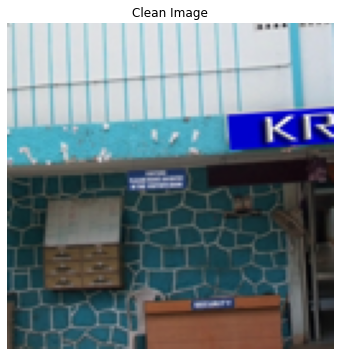

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(krishna)
plt.title("Clean Image")
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

### NLM Filtering
Display the noisy image and results of NML filtering for different values of $\sigma_{NLM}$ and $W$. $W_{sim}$ is taken to be $3$ for all of the cases.

#### W = 3

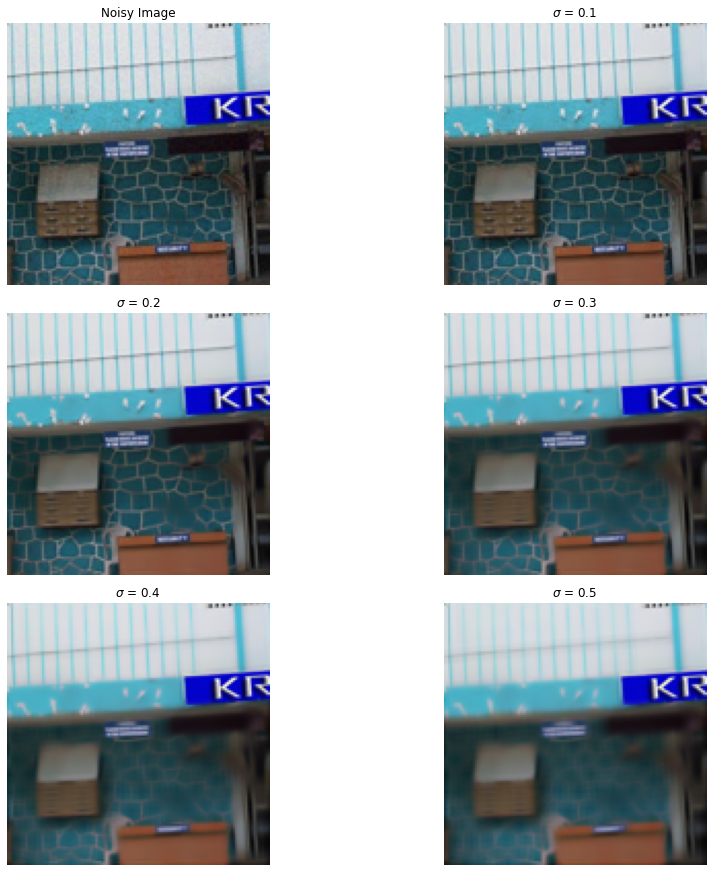

In [15]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(12, 12), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')
ax1.imshow(krishna_noisy)
ax1.title.set_text(rf"Noisy Image")
ax2.imshow(NLM_data[(sigma_vals[0], W_vals[0])][0])
ax2.title.set_text(rf"$\sigma$ = {sigma_vals[0]}")
ax3.imshow(NLM_data[(sigma_vals[1], W_vals[0])][0])
ax3.title.set_text(rf"$\sigma$ = {sigma_vals[1]}")
ax4.imshow(NLM_data[(sigma_vals[2], W_vals[0])][0])
ax4.title.set_text(rf"$\sigma$ = {sigma_vals[2]}")
ax5.imshow(NLM_data[(sigma_vals[3], W_vals[0])][0])
ax5.title.set_text(rf"$\sigma$ = {sigma_vals[3]}")
ax6.imshow(NLM_data[(sigma_vals[4], W_vals[0])][0])
ax6.title.set_text(rf"$\sigma$ = {sigma_vals[4]}")
plt.show()

#### W = 5

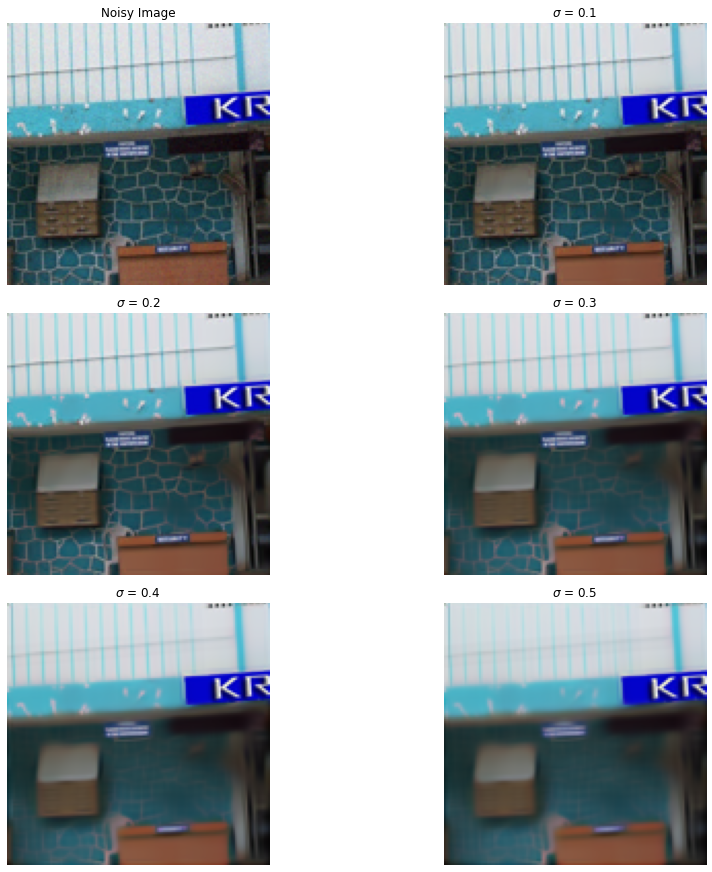

In [16]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(12, 12), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')
ax1.imshow(krishna_noisy)
ax1.title.set_text(rf"Noisy Image")
ax2.imshow(NLM_data[(sigma_vals[0], W_vals[1])][0])
ax2.title.set_text(rf"$\sigma$ = {sigma_vals[0]}")
ax3.imshow(NLM_data[(sigma_vals[1], W_vals[1])][0])
ax3.title.set_text(rf"$\sigma$ = {sigma_vals[1]}")
ax4.imshow(NLM_data[(sigma_vals[2], W_vals[1])][0])
ax4.title.set_text(rf"$\sigma$ = {sigma_vals[2]}")
ax5.imshow(NLM_data[(sigma_vals[3], W_vals[1])][0])
ax5.title.set_text(rf"$\sigma$ = {sigma_vals[3]}")
ax6.imshow(NLM_data[(sigma_vals[4], W_vals[1])][0])
ax6.title.set_text(rf"$\sigma$ = {sigma_vals[4]}")
plt.show()

### Gaussian Filtering
Display the noisy image and results of NML filtering for different values of $\sigma_{g}$. The window size is held constant at $7\times 7$

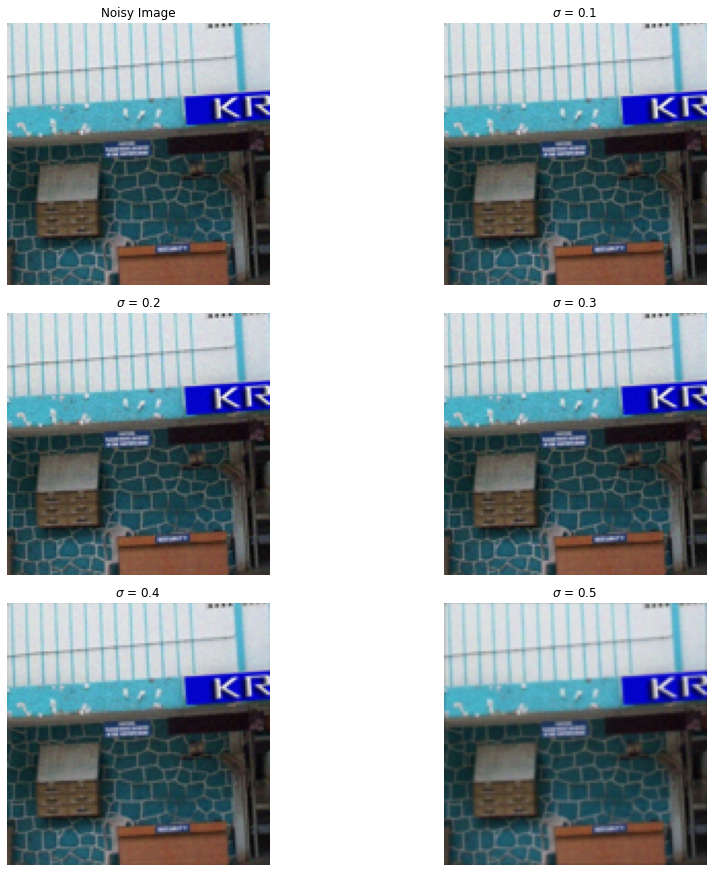

In [17]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(12, 12), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')
ax1.imshow(krishna_noisy)
ax1.title.set_text(rf"Noisy Image")
ax2.imshow(Gaussian_data[sigma_vals[0]][0])
ax2.title.set_text(rf"$\sigma$ = {sigma_vals[0]}")
ax3.imshow(Gaussian_data[sigma_vals[1]][0])
ax3.title.set_text(rf"$\sigma$ = {sigma_vals[1]}")
ax4.imshow(Gaussian_data[sigma_vals[2]][0])
ax4.title.set_text(rf"$\sigma$ = {sigma_vals[2]}")
ax5.imshow(Gaussian_data[sigma_vals[3]][0])
ax5.title.set_text(rf"$\sigma$ = {sigma_vals[3]}")
ax6.imshow(Gaussian_data[sigma_vals[4]][0])
ax6.title.set_text(rf"$\sigma$ = {sigma_vals[4]}")
plt.show()

### PSNR
Plot the PSNR in dB for different set of parameters. The baseline PSNR is between the provided noisy image and its underlying clean image.

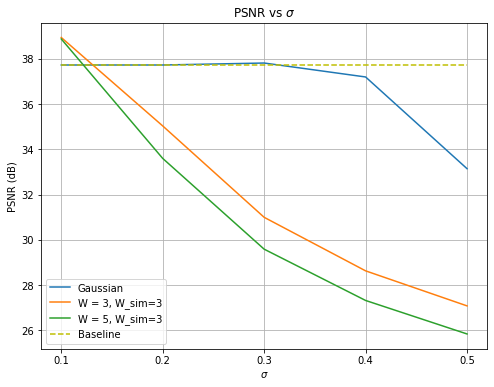

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(sigma_vals, [Gaussian_data[sigma][1] for sigma in sigma_vals])
plt.plot(sigma_vals, [NLM_data[(sigma, W_vals[0])][1] for sigma in sigma_vals])
plt.plot(sigma_vals, [NLM_data[(sigma, W_vals[1])][1] for sigma in sigma_vals])
plt.plot(sigma_vals, [PSNR(krishna, krishna_noisy)
                      for sigma in sigma_vals], 'y--')
plt.xlabel(r"${\sigma}$")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend(["Gaussian", "W = 3, W_sim=3", "W = 5, W_sim=3", "Baseline"])
plt.xticks(sigma_vals)
plt.title(r"PSNR vs $\sigma$")
plt.show()

### Visualize Kernels
Visualize the kernels used in Gaussian and NLM filtering. For Gaussian filtering, a $11\times 11$ kernel with $\sigma_{g}=1$ is used. For NLM filtering, we use $\sigma_{NLM}=0.5, W=5, W_{sim}=3$. The resulting $11\times 11$ kernels are shows for the given locations.

#### Gaussian Kernel
Have a look at the Gaussian kernel first.

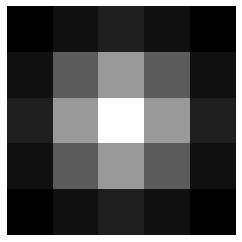

In [ ]:
plt.figure(figsize=(4.2, 4.2))
plt.imshow(gaussian_kernel(sigma=1, w=5), 'gray')
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

#### NLM Kernels
NLM kernels at the different locations are shown

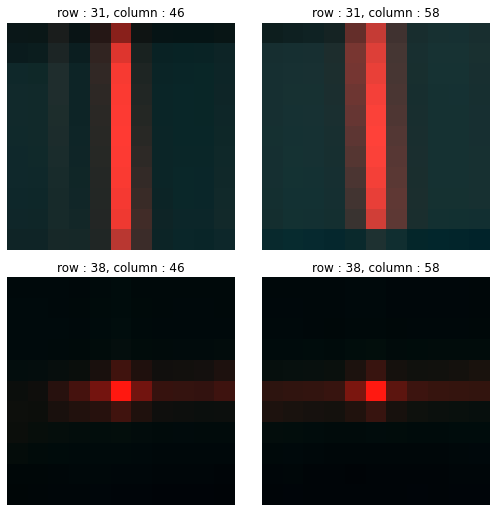

In [ ]:
visualize(krishna, rows[0], columns[0], rows[1],
          columns[1], W=5, W_sim=3, sigma=0.5, is_kernel=True)

### Filtering Results
Patches around the given pixels from the noisy and filtered images are shown

#### Noisy Image Patches

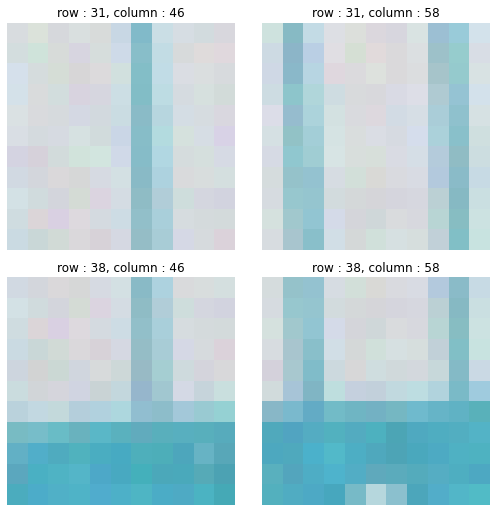

In [ ]:
visualize(krishna_noisy, rows[0], columns[0],
          rows[1], columns[1], W=5, is_kernel=False)

#### NLM Filtering Results

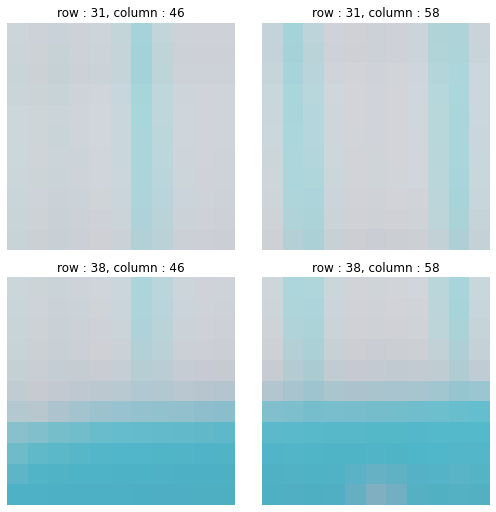

In [ ]:
visualize(NLM_data[(0.5, 5)][0], rows[0], columns[0],
          rows[1], columns[1], W=5, is_kernel=False)

#### Gaussian Filtering Results

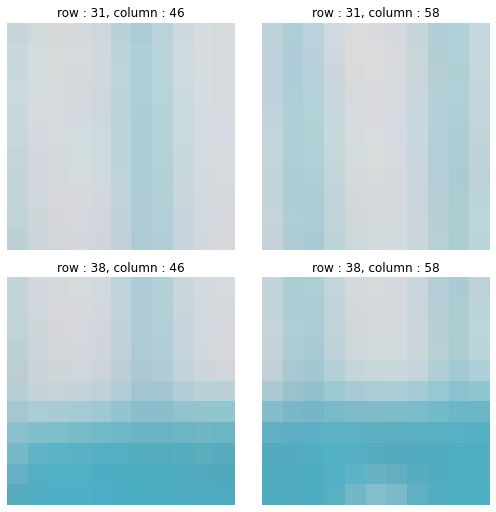

In [ ]:
visualize(gaussian_denoising_RGB(krishna_noisy, sigma=1, w=5),
          rows[0], columns[0], rows[1], columns[1], W=5, is_kernel=False)

#### NLM Filtering Results (Different Parameters)
Visualize the results for NLM filtering with parameters $\sigma_{NLM}=0.1, W=3, W_{sim}=3$

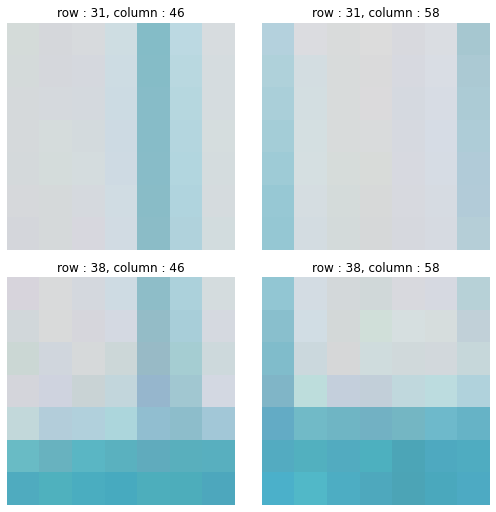

In [ ]:
visualize(NLM_data[(0.1, 5)][0], rows[0], columns[0],
          rows[1], columns[1], W=3, is_kernel=False)

##**Observations**

The following observations can be made:
- NLM filtering with $\sigma_{NLM}=0.1$ reduces the noise significantly and also preserves the edges. 
- Gaussian filtering for lower values of $\sigma_{g}$ makes close to no difference to the visual look of the images. This is also reflected in the PSNR value which is very similar to the baseline image.
- Increasing $\sigma_{g}$ or $\sigma_{NLM}$ deteriorates the performance of the filtering processes. NLM filtering suffers from a lot more blurring than Gaussian filtering on doing this.
- For higher values of $\sigma_{NLM}$, NLM filtering performance is worse for larger values of $W$. This is reflected in the PSNR values.
- NLM filtering is computationally a lot more expensive than Gaussian filtering. 
- A sweet spot, both on visual inspection and looking at the PSNR curves, is obtained for NLM filtering with parameters $\sigma_{NLM}=0.1, W_{sim}=3$. Beyond this $\sigma_{NLM}$, the sharpness lost makes the image much worse than the slight improvements obtained in noise levels.
